[[0, 1.0], [0, 2.0], [500, 1.0], [500, 2.0], [1000, 1.0]]
★Candidate Plans 濃度一覧も [0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

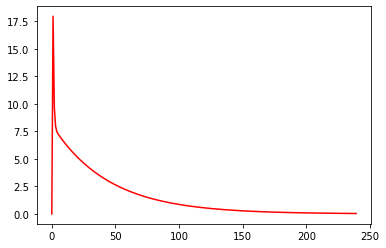

In [1]:
# 無駄話が多いようですが必要なことしか記載しておりません！
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
import CCR
import itertools


# 施設名  ID  患者名  性別(M/F)
# 年齢    身長    体重    BUN 血清クレアチニン    血清アルブミン
PTDATA = ['Hospital', '1234-5678-9012', 'YohYasushi', 'M',
          38, 170.0, 60.0, 10.7, 3.0, 4.0]

# 投与量パターン・点滴時間　※多ければ多いほど処理に時間がかかります
DOSETYPE = [0, 500, 1000]  # 1時間あたりの投与量のリスト
TIMEINF = [1.0, 2.0]  # 点滴注射にかける時間のリスト

# PTDATAから各要素の抽出
INST = str(PTDATA[0])
IDNUM = str(PTDATA[1])
NAME = str(PTDATA[2])
HEIGHT = float(PTDATA[5])
GENDER = str(PTDATA[3])
AGE = float(PTDATA[4])
WEIGHT = float(PTDATA[6])
SBUN = float(PTDATA[7])
SCR = float(PTDATA[8])
SALB = float(PTDATA[9])

# ピークの目標濃度入力
Peak_max = 40
Peak_min = 25

# トラフの目標濃度入力
Trough_max = 20
Trough_min = 15

#ここで腎機能計算－－－－－－－－－－CCRをImport

CCR= CCR.CCR(GENDER, AGE, SCR, WEIGHT)

#ここで血中濃度計算－－－－－－－－－－

# 血中濃度計算　パラーメーター各種
k12 = 1.1199  # /hr
k21 = 0.4801  # /hr
V1 = 17.520 # L
DrugCL = CCR * 0.797 * 60 / 1000 / WEIGHT # 0.797は薬CL=0.797*CCRの意味 さらにml/min/kg -> L/hr/kgへ単位変換のため
VD = V1 / WEIGHT
k10 = DrugCL / VD # keと同じこと 排泄クリアランスの定数？
alpha = ((k12 + k21 + k10) + math.sqrt((k12 + k21 + k10) ** 2 - (4 * k21 * k10))) / 2
beta =  ((k12 + k21 + k10) - math.sqrt((k12 + k21 + k10) ** 2 - (4 * k21 * k10))) / 2

# 血中濃度Cp
# k0 = 1時間あたりの投与量(mg/hour)　の意味です
# T: (そのトラフの元となるピーク生成の)投与の最初からの経過時間
def Cp(k0, T, Tinf):
    if T <= Tinf: # ピークまで
        a = (k0 * (k21 - alpha))/(V1 * alpha * (beta - alpha)) * (1 - math.exp(- alpha * T)) + \
        (k0 * (k21 - beta))/(V1 * beta * (alpha - beta )) * (1 - math.exp(- beta * T))
    else: #ピーク以後
        a = ( (k0 * (k21 - alpha))/(V1 * alpha * (beta - alpha)) * (1 - math.exp(- alpha * Tinf)) ) * \
        math.exp(-alpha * (T-Tinf)) + \
        ( (k0 * (k21 - beta))/(V1 * beta * (alpha - beta )) * (1 - math.exp(- beta * Tinf)) )* \
        math.exp(-beta * (T-Tinf))
    return a

#血中濃度計算ここまで－－－－－－－－－－

# ピーク濃度危険域の判断 ピークMAXを超えない1時間あたりの
# 投与時間と投与量の組み合わせ候補の生成
CANDPLAN = []
for i in range(len(DOSETYPE)):
    for j in range(len(TIMEINF)):
        if Cp(DOSETYPE[i], TIMEINF[j], TIMEINF[j]) <= Peak_max: # 初回投与のピーク濃度がPeak_max以下ということ
            CANDPLAN.append([DOSETYPE[i], TIMEINF[j]])
    else:
        pass
print(CANDPLAN)

# 血中濃度リスト作成
# CANDPLANごとに240時間さきまでの1時間毎の血中濃度をリストで作成
CANDPLANConc = [None]* len(CANDPLAN)
for i in range(len(CANDPLAN)):
    c = []
    for j in range(0, 240, 1): # 10日先=240時間先まで計算する 無駄があるけどこれは固定する
        c.append(Cp(CANDPLAN[i][0], j, CANDPLAN[i][1]))
    CANDPLANConc[i] = c
for i in range(len(CANDPLAN)):
    print('★Candidate Plans 濃度一覧も', CANDPLAN[i], CANDPLANConc[i])

#一応グラフ化
x = np.arange(0, 240)
y1 =  CANDPLANConc[2]
plt.plot(x, y1, color='red')
plt.show()